<img src="../images/full-jtech-d-15-0020_1-f4.jpg" width=700 alt="QVP plot"></img>

Courtesy: Rizhkov, et al. (2014)

# Reproducing Ryzhkov et al. (2016) QVP Analysis: Traditional vs ARCO Workflows

This notebook demonstrates the benefits of **Analysis-Ready Cloud-Optimized (ARCO)** radar data by reproducing **Figure 4** from [Ryzhkov et al. (2016)](https://doi.org/10.1175/JTECH-D-15-0020.1) using two contrasting approaches.

As defined by [Abernathey et al. (2021)](https://doi.org/10.1109/MCSE.2021.3059437), ARCO data represents the "gold standard" for cloud-native scientific data repositories, combining:
- **Analysis-Ready**: Data prepared for immediate exploration without preprocessing
- **Cloud-Optimized**: Chunked formats (Zarr) enabling efficient HTTP-based access

```{list-table} Workflow Comparison Overview
:header-rows: 1
:widths: 25 35 35

* - Aspect
  - Traditional Workflow
  - ARCO Data Streaming
* - **Data Access**
  - Download full files
  - Stream chunks on-demand
* - **I/O Pattern**
  - Download → Decode → Process
  - Lazy open → Select → Stream
* - **Sweeps Loaded**
  - All 17 sweeps per file
  - Only requested sweep(s)
* - **Variables Loaded**
  - All variables in file
  - Only requested variables
* - **Time Selection**
  - Parse filenames, filter list
  - Native `vcp_time.sel()` slice
* - **Throughput**
  - Limited by download + decode
  - Scales with parallelism
```

**Scientific Goal**: Compute Quasi-Vertical Profiles (QVPs) of Z, Z_DR, ρ_HV, and Φ_DP for the May 20, 2011 MCS observed by KVNX radar during MC3E.

---

## Study Parameters

We'll analyze an expanded time window to capture more storm evolution:
- **Radar**: KVNX (Vance Air Force Base, Oklahoma)
- **Date**: May 20, 2011 (MC3E field campaign)
- **Time Window**: 08:30 - 12:30 UTC (4 hours)
- **Elevation**: 19.5° (highest WSR-88D elevation, sweep_16)
- **Variables**: DBZH, ZDR, RHOHV, PHIDP

In [1]:
!uv pip install git+https://github.com/aladinor/xarray.git@async-dtreec

Using Python 3.13.7 environment at: /home/alfonso-ladino/python/raw2zarr/.venv
Resolved 8 packages in 260ms                                         
Audited 8 packages in 0.13ms


In [2]:
import time
import tracemalloc  # For memory tracking
import warnings

# Suppress FutureWarning from xradar/xarray
warnings.filterwarnings("ignore", category=FutureWarning)

import cmweather  # noqa: F401
import icechunk as ic
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from demo_functions import (
    compute_qvp,
    get_repo_config,
    list_nexrad_files_with_sizes,
    nexrad_download_with_size,
    ryzhkov_figure,
)

# Study parameters - expanded time window (4 hours)
RADAR = "KVNX"
START_TIME = "2011-05-20 08:30"
END_TIME = "2011-05-20 12:30"
VARIABLES = ["DBZH", "ZDR", "RHOHV", "PHIDP"]

# Metrics collection
metrics = {"traditional": {}, "arco": {}}

In [3]:
print(f"xarray: {xr.__version__}")
print(f"icechunk: {ic.__version__}")

xarray: 10000.dev6326+g5c2f62cab
icechunk: 2.0.0a0-dev63+g9c26b40


---
## Approach 1: Traditional File-Based Workflow

The conventional approach requires:
1. **Discovery**: Query S3 bucket to list files in time range
2. **Download**: Fetch each compressed Level II file
3. **Decode**: Parse binary format into datatree
4. **Extract**: Select the 19.5° sweep from each volume
5. **Aggregate**: Manually concatenate along time
6. **Compute**: Calculate QVP for each timestep

### Step 1: Discover files in the time range

In [4]:
# List all NEXRAD files with actual sizes from AWS S3 using fsspec
t0 = time.time()
nexrad_files = list_nexrad_files_with_sizes(
    radar=RADAR, start_time=START_TIME, end_time=END_TIME
)
metrics["traditional"]["discovery_time"] = time.time() - t0
metrics["traditional"]["n_files"] = len(nexrad_files)
metrics["traditional"]["total_size_bytes"] = sum(f["size"] for f in nexrad_files)
metrics["traditional"]["total_size_mb"] = metrics["traditional"]["total_size_bytes"] / (
    1024 * 1024
)

print(f"Found {len(nexrad_files)} files in the time range")
print(
    f"First file: {nexrad_files[0]['path'].split('/')[-1]} ({nexrad_files[0]['size'] / 1e6:.1f} MB)"
)
print(
    f"Last file:  {nexrad_files[-1]['path'].split('/')[-1]} ({nexrad_files[-1]['size'] / 1e6:.1f} MB)"
)
print(f"\nTotal data volume: {metrics['traditional']['total_size_mb']:.1f} MB")
print(f"Discovery time: {metrics['traditional']['discovery_time']:.2f}s")

Found 55 files in the time range
First file: KVNX20110520_083314_V06.gz (15.0 MB)
Last file:  KVNX20110520_122911_V06.gz (14.0 MB)

Total data volume: 808.9 MB
Discovery time: 0.59s


### Step 2: Download, decode, and extract sweeps

This is the most expensive part - each file must be:
- Downloaded from S3 (~30 MB compressed per file)
- Decompressed
- Decoded from binary NEXRAD format
- Parsed into xarray structures

**Note**: We'll process a subset to demonstrate the workflow without excessive wait times.

In [5]:
# Process ALL files - download, decode, extract sweep_16, and store in memory
# This demonstrates the full traditional workflow with actual memory usage

t0 = time.time()
tracemalloc.start()  # Start memory tracking

sweep_datasets = []  # Store actual xarray datasets in memory
download_times = []
bytes_downloaded = 0

print(f"Processing all {len(nexrad_files)} files...")
print("-" * 60)

for i, file_info in enumerate(nexrad_files):
    try:
        # Download and decode
        t_download = time.time()
        dtree_single, size_bytes = nexrad_download_with_size(file_info["path"])
        download_times.append(time.time() - t_download)
        bytes_downloaded += size_bytes

        # Find the highest elevation sweep (~19.5°)
        sweeps = [s for s in dtree_single.children if s.startswith("sweep_")]
        sweeps.sort(key=lambda x: int(x.split("_")[1]))
        highest_sweep = sweeps[-1]

        # Extract and LOAD the sweep dataset into memory
        ds = dtree_single[highest_sweep].ds.load()  # .load() forces into RAM

        # Add time coordinate for concatenation
        sweep_time = ds.time.values[0]
        ds = ds.expand_dims({"vcp_time": [sweep_time]})

        sweep_datasets.append(ds)

        if (i + 1) % 10 == 0 or (i + 1) == len(nexrad_files):
            current_mem, peak_mem = tracemalloc.get_traced_memory()
            print(
                f"  [{i + 1}/{len(nexrad_files)}] {file_info['path'].split('/')[-1]} - "
                f"RAM: {current_mem / 1e6:.0f} MB (peak: {peak_mem / 1e6:.0f} MB)"
            )

    except Exception as e:
        print(f"  [{i + 1}/{len(nexrad_files)}] Failed: {e}")

# Get final memory stats
current_mem, peak_mem = tracemalloc.get_traced_memory()
tracemalloc.stop()

metrics["traditional"]["total_time"] = time.time() - t0
metrics["traditional"]["avg_download_time"] = np.mean(download_times)
metrics["traditional"]["files_processed"] = len(sweep_datasets)
metrics["traditional"]["bytes_downloaded"] = bytes_downloaded
metrics["traditional"]["peak_memory_mb"] = peak_mem / 1e6
metrics["traditional"]["final_memory_mb"] = current_mem / 1e6

print("-" * 60)
print(
    f"Downloaded and loaded {len(sweep_datasets)} files in {metrics['traditional']['total_time']:.1f}s"
)
print(f"Network transfer: {bytes_downloaded / 1e6:.1f} MB (compressed)")
print(f"Peak RAM usage: {peak_mem / 1e6:.0f} MB")
print(
    f"Average time per file: {metrics['traditional']['total_time'] / len(sweep_datasets):.2f}s"
)

Processing all 55 files...
------------------------------------------------------------
  [10/55] KVNX20110520_091212_V06.gz - RAM: 711 MB (peak: 808 MB)
  [20/55] KVNX20110520_095727_V06.gz - RAM: 1388 MB (peak: 1410 MB)
  [30/55] KVNX20110520_104047_V06.gz - RAM: 1737 MB (peak: 1972 MB)
  [40/55] KVNX20110520_112410_V06.gz - RAM: 2410 MB (peak: 2431 MB)
  [50/55] KVNX20110520_120731_V06.gz - RAM: 2759 MB (peak: 3085 MB)
  [55/55] KVNX20110520_122911_V06.gz - RAM: 3253 MB (peak: 3274 MB)
------------------------------------------------------------
Downloaded and loaded 55 files in 255.3s
Network transfer: 848.2 MB (compressed)
Peak RAM usage: 3274 MB
Average time per file: 4.64s


### Traditional Workflow: Estimated Full Processing Time

In [6]:
# Concatenate all sweep datasets and compute QVPs (traditional approach)
print("Concatenating datasets along time dimension...")
t0_concat = time.time()

tracemalloc.start()
ds_traditional = xr.concat(sweep_datasets, dim="vcp_time")
concat_time = time.time() - t0_concat

# Compute QVPs using the traditional concatenated dataset
t0_qvp = time.time()
qvp_traditional = {}
for var in VARIABLES:
    if var in ds_traditional.data_vars:
        data = ds_traditional[var]
        units = data.attrs.get("units", "")
        if units.startswith("dB"):
            qvp_val = 10 * np.log10((10 ** (data / 10)).mean("azimuth", skipna=True))
        else:
            qvp_val = data.mean("azimuth", skipna=True)
        qvp_traditional[var] = qvp_val
qvp_compute_time = time.time() - t0_qvp

current_mem, peak_mem = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Update metrics with actual (not extrapolated) values
metrics["traditional"]["concat_time"] = concat_time
metrics["traditional"]["qvp_compute_time"] = qvp_compute_time
metrics["traditional"]["concat_peak_memory_mb"] = peak_mem / 1e6
metrics["traditional"]["total_workflow_time"] = (
    metrics["traditional"]["total_time"] + concat_time + qvp_compute_time
)

print("=" * 60)
print("TRADITIONAL WORKFLOW - ACTUAL COSTS (ALL FILES)")
print("=" * 60)
print(f"Files processed:               {metrics['traditional']['files_processed']}")
print(f"Download + decode time:        {metrics['traditional']['total_time']:.1f}s")
print(f"Concatenation time:            {concat_time:.2f}s")
print(f"QVP computation time:          {qvp_compute_time:.2f}s")
print(
    f"TOTAL WORKFLOW TIME:           {metrics['traditional']['total_workflow_time']:.1f}s ({metrics['traditional']['total_workflow_time'] / 60:.1f} min)"
)
print("-" * 60)
print(
    f"Network transfer (compressed): {metrics['traditional']['total_size_mb']:.1f} MB"
)
print(
    f"Peak RAM (download phase):     {metrics['traditional']['peak_memory_mb']:.0f} MB"
)
print(
    f"Peak RAM (concat phase):       {metrics['traditional']['concat_peak_memory_mb']:.0f} MB"
)
print("=" * 60)

# Show concatenated dataset info
print("\nConcatenated dataset shape:")
print(f"  Time steps: {len(ds_traditional.vcp_time)}")
print(f"  Azimuth: {len(ds_traditional.azimuth)}")
print(f"  Range: {len(ds_traditional.range)}")
print(f"  Variables: {list(ds_traditional.data_vars)[:6]}...")

Concatenating datasets along time dimension...
TRADITIONAL WORKFLOW - ACTUAL COSTS (ALL FILES)
Files processed:               55
Download + decode time:        255.3s
Concatenation time:            1.71s
QVP computation time:          1.67s
TOTAL WORKFLOW TIME:           258.7s (4.3 min)
------------------------------------------------------------
Network transfer (compressed): 808.9 MB
Peak RAM (download phase):     3274 MB
Peak RAM (concat phase):       5793 MB

Concatenated dataset shape:
  Time steps: 55
  Azimuth: 2383
  Range: 460
  Variables: ['DBZH', 'VRADH', 'WRADH', 'ZDR', 'PHIDP', 'RHOHV']...


---
## Approach 2: Radar DataTree (ARCO) with Data Streaming

The cloud-native approach with Radar DataTree uses **on-demand data streaming**:
1. **Connect**: Open Icechunk repository (metadata only, no data transfer)
2. **Navigate**: Browse VCPs and sweeps via hierarchical structure  
3. **Select**: Slice by native `vcp_time` dimension (lazy, no data yet)
4. **Stream**: Data chunks are fetched on-demand during computation

**Key difference**: No file downloads, no decoding overhead. Data streams directly from cloud storage as needed.

### Step 1: Connect to Icechunk repository

In [7]:
%%time
t0 = time.time()

# Configure S3-compatible storage (OSN)
storage = ic.s3_storage(
    bucket="nexrad-arco",
    prefix="KVNX",
    endpoint_url="https://umn1.osn.mghpcc.org",
    anonymous=True,
    force_path_style=True,
    region="us-east-1",
)

# Connect to repository with optimized config
repo_config = get_repo_config()
repo = ic.Repository.open(storage, config=repo_config)
session = repo.readonly_session("main")

metrics["arco"]["connect_time"] = time.time() - t0
print(f"Connected to Icechunk repository in {metrics['arco']['connect_time']:.2f}s")

Connected to Icechunk repository in 0.47s
CPU times: user 53.6 ms, sys: 1.95 ms, total: 55.5 ms
Wall time: 467 ms


Open the radar datatree using xarray.

In [8]:
%%time
t0 = time.time()

dtree = xr.open_datatree(
    session.store,
    engine="zarr",
    zarr_format=3,
    consolidated=False,
    chunks={},
)

metrics["arco"]["open_datatree_time"] = time.time() - t0
print(f"Opened DataTree in {metrics['arco']['open_datatree_time']:.2f}s")

Opened DataTree in 4.64s
CPU times: user 2.3 s, sys: 308 ms, total: 2.6 s
Wall time: 4.64 s


### Step 2: Explore the hierarchical structure

One key advantage of the DataTree model: all VCPs, sweeps, and elevation angles are organized in a navigable hierarchy.

In [9]:
list(dtree.children)

['VCP-11', 'VCP-12', 'VCP-212']

Select the highest elevation sweep for QVP computation. Use the last sweep (highest angle) available.

In [10]:
# Get available sweeps and select the highest elevation angle
available_sweeps = [
    child for child in dtree["VCP-12"].children if child.startswith("sweep_")
]
available_sweeps.sort(key=lambda x: int(x.split("_")[1]))  # Sort by sweep number

available_sweeps

['sweep_0',
 'sweep_1',
 'sweep_2',
 'sweep_3',
 'sweep_4',
 'sweep_5',
 'sweep_6',
 'sweep_7',
 'sweep_8',
 'sweep_9',
 'sweep_10',
 'sweep_11',
 'sweep_12',
 'sweep_13',
 'sweep_14',
 'sweep_15',
 'sweep_16']

In [11]:
# Use the highest numbered sweep (typically highest elevation)
highest_sweep = available_sweeps[-1]
print(f"Using {highest_sweep} for QVP computation")

ds_qvp = dtree[f"/VCP-12/{highest_sweep}"].ds

Using sweep_16 for QVP computation


### Step 3: Select time window and compute QVPs

Unlike the traditional workflow that requires iterating through files, we can directly slice the data using the native `vcp_time` dimension. The entire 4-hour window is accessed with a single selection.

In [12]:
# Select the 4-hour time window
# With ARCO format, this is a simple slice operation - no file iteration needed
ds_qvp_selected = ds_qvp.sel(
    vcp_time=slice(START_TIME.replace(" ", "T"), END_TIME.replace(" ", "T"))
)
print(
    f"Time range: {ds_qvp_selected.vcp_time.min().values} to {ds_qvp_selected.vcp_time.max().values}"
)
print(f"Number of timesteps: {len(ds_qvp_selected.vcp_time)}")

Time range: 2011-05-20T08:33:14.127000000 to 2011-05-20T12:29:11.734000000
Number of timesteps: 55


In [19]:
# Calculate ARCO streaming metrics - data fetched on-demand
def calculate_chunk_metrics(ds, variables):
    """Calculate the actual number of chunks and bytes streamed for the selection."""
    total_chunks = 0
    total_bytes = 0
    chunk_details = {}

    for var in variables:
        if var not in ds.data_vars:
            continue

        da = ds[var]

        if da.chunks is not None:
            chunks = da.chunks

            # Number of chunks streamed = product of chunk counts in each dimension
            n_chunks = 1
            for dim_chunks in chunks:
                n_chunks *= len(dim_chunks)

            # Calculate bytes (actual data transferred - no compression in this dataset)
            dtype_size = da.dtype.itemsize
            var_bytes = dtype_size * da.size

            # Get chunk shape
            chunk_shape = tuple(c[0] if c else 1 for c in chunks)
            chunk_bytes = dtype_size * np.prod(chunk_shape)

            chunk_details[var] = {
                "n_chunks": n_chunks,
                "chunk_shape": chunk_shape,
                "chunk_size_mb": chunk_bytes / 1e6,
                "total_bytes": var_bytes,
            }
            total_chunks += n_chunks
            total_bytes += var_bytes

    return total_chunks, total_bytes, chunk_details


n_chunks, arco_bytes, chunk_details = calculate_chunk_metrics(
    ds_qvp_selected, VARIABLES
)

# Traditional: NEXRAD files are gzip compressed ~4:1
# They decompress to full uncompressed size in RAM during decode
COMPRESSION_RATIO = 4.0
traditional_uncompressed = metrics["traditional"]["total_size_mb"] * COMPRESSION_RATIO

print("DATA ACCESS ANALYSIS:")
print("=" * 70)
print()
print("ARCO - Selective Chunk Streaming (sweep_16, 4 variables):")
print("-" * 70)
print("  NOTE: No compression in this ARCO dataset - network = data size")
print()
for var, details in chunk_details.items():
    print(
        f"  {var}: {details['n_chunks']} chunks × {details['chunk_size_mb']:.2f} MB = {details['total_bytes'] / 1e6:.1f} MB"
    )
print("-" * 70)
print(f"  Total chunks streamed:  {n_chunks}")
print(f"  Network transfer:       {arco_bytes / 1e6:.1f} MB")
print()
print("TRADITIONAL - Full File Downloads (all 17 sweeps, all variables):")
print("-" * 70)
print(
    f"  Network transfer:       {metrics['traditional']['total_size_mb']:.1f} MB (gzip compressed)"
)
print(f"  Decompressed in RAM:    ~{traditional_uncompressed:.0f} MB")
print(
    f"  Data actually used:     ~{traditional_uncompressed / 17:.0f} MB (1/17 = sweep_16 only)"
)
print()
print("=" * 70)
print("SELECTIVE ACCESS ADVANTAGE:")
print(
    f"  Network: ARCO {arco_bytes / 1e6:.0f} MB vs Traditional {metrics['traditional']['total_size_mb']:.0f} MB"
)
print(
    f"           → {metrics['traditional']['total_size_mb'] / (arco_bytes / 1e6):.1f}x less data transferred"
)
print(
    f"  RAM:     ARCO streams on-demand vs Traditional loads {traditional_uncompressed:.0f} MB"
)
print(
    f"           → {traditional_uncompressed / (arco_bytes / 1e6):.0f}x less data processed"
)
print("=" * 70)

metrics["arco"]["n_chunks"] = n_chunks
metrics["arco"]["uncompressed_mb"] = arco_bytes / 1e6
metrics["traditional"]["uncompressed_mb"] = traditional_uncompressed

DATA ACCESS ANALYSIS:

ARCO - Selective Chunk Streaming (sweep_16, 4 variables):
----------------------------------------------------------------------
  NOTE: No compression in this ARCO dataset - network = data size

  DBZH: 55 chunks × 0.66 MB = 36.4 MB
  ZDR: 55 chunks × 0.66 MB = 36.4 MB
  RHOHV: 55 chunks × 0.66 MB = 36.4 MB
  PHIDP: 55 chunks × 0.66 MB = 36.4 MB
----------------------------------------------------------------------
  Total chunks streamed:  220
  Network transfer:       145.7 MB

TRADITIONAL - Full File Downloads (all 17 sweeps, all variables):
----------------------------------------------------------------------
  Network transfer:       808.9 MB (gzip compressed)
  Decompressed in RAM:    ~3236 MB
  Data actually used:     ~190 MB (1/17 = sweep_16 only)

SELECTIVE ACCESS ADVANTAGE:
  Network: ARCO 146 MB vs Traditional 809 MB
           → 5.6x less data transferred
  RAM:     ARCO streams on-demand vs Traditional loads 3236 MB
           → 22x less data proce

In [20]:
%%time
t0 = time.time()

# Compute QVP for multiple radar variables (vectorized across all timesteps)
qvp_data = {}

for var in VARIABLES:
    if var in ds_qvp_selected.data_vars:
        qvp_data[var] = compute_qvp(ds_qvp_selected, var=var).compute()
        print(f"Computed QVP for {var}")
    else:
        print(f"Warning: Variable {var} not found in dataset")

metrics["arco"]["qvp_compute_time"] = time.time() - t0
metrics["arco"]["timesteps"] = len(ds_qvp_selected.vcp_time)
print(
    f"\nProcessed {metrics['arco']['timesteps']} timesteps in {metrics['arco']['qvp_compute_time']:.1f}s"
)

Computed QVP for DBZH
Computed QVP for ZDR
Computed QVP for RHOHV
Computed QVP for PHIDP

Processed 55 timesteps in 2.2s
CPU times: user 1.23 s, sys: 102 ms, total: 1.34 s
Wall time: 2.24 s


Figure saved as 'ryzhkov_qvp_reproduction.png'


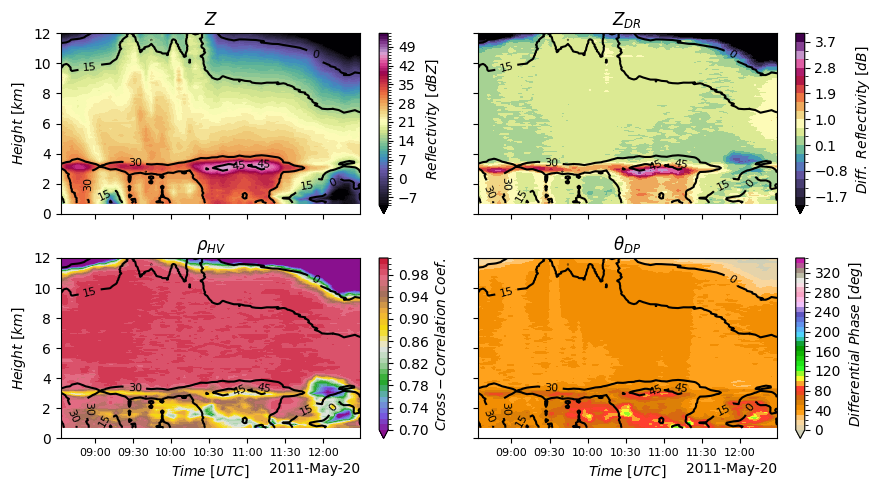

In [15]:
# Reproduce Ryzhkov et al. (2016) Figure 4: QVP time-height cross-sections
ryzhkov_figure(qvp_data["DBZH"], qvp_data["ZDR"], qvp_data["RHOHV"], qvp_data["PHIDP"])
plt.savefig("ryzhkov_qvp_reproduction.png", dpi=150, bbox_inches="tight")
print("Figure saved as 'ryzhkov_qvp_reproduction.png'")

### ARCO Workflow: Total Time

In [21]:
# Calculate total ARCO workflow time
metrics["arco"]["total_time"] = (
    metrics["arco"]["connect_time"]
    + metrics["arco"]["open_datatree_time"]
    + metrics["arco"]["qvp_compute_time"]
)

print("=" * 60)
print("ARCO DATA STREAMING - PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Timesteps processed:           {metrics['arco']['timesteps']}")
print(
    f"Connect to repository:         {metrics['arco']['connect_time']:.2f}s (metadata only)"
)
print(
    f"Open DataTree:                 {metrics['arco']['open_datatree_time']:.2f}s (lazy, no data)"
)
print(f"Compute QVPs (data streams):   {metrics['arco']['qvp_compute_time']:.2f}s")
print(f"Total time:                    {metrics['arco']['total_time']:.1f} seconds")
print("-" * 60)
print(f"Chunks streamed on-demand:     {metrics['arco']['n_chunks']}")
print(
    f"Data streamed (network):       {metrics['arco']['uncompressed_mb']:.1f} MB (no compression)"
)
print("=" * 60)

ARCO DATA STREAMING - PERFORMANCE SUMMARY
Timesteps processed:           55
Connect to repository:         0.47s (metadata only)
Open DataTree:                 4.64s (lazy, no data)
Compute QVPs (data streams):   2.24s
Total time:                    7.3 seconds
------------------------------------------------------------
Chunks streamed on-demand:     220
Data streamed (network):       145.7 MB (no compression)


---
## Performance Comparison: Traditional vs ARCO

Now let's compare the two approaches quantitatively.

In [22]:
# =============================================================================
# FAIR THROUGHPUT COMPARISON - Methodology
# =============================================================================
# Following Abernathey et al. (2021), we measure "effective data throughput":
#   Throughput = Useful data delivered to analysis / Total workflow time
#
# This metric captures the end-to-end efficiency of each approach.
#
# TRADITIONAL WORKFLOW:
#   - Downloads 809 MB compressed files from S3
#   - Decompresses and decodes into ~3,274 MB in RAM (measured via tracemalloc)
#   - But we only USE sweep_16 with 4 variables = ~146 MB useful data
#   - Total workflow time includes: download + decompress + decode + concat + compute
#
# ARCO WORKFLOW:
#   - Streams ONLY the data we need: 146 MB (4 vars × 55 timesteps × 1 sweep)
#   - No compression in this dataset - network transfer = data size
#   - Advantage is SELECTIVE ACCESS, not compression
#   - Total workflow time: connect + open + compute
#
# This is a FAIR comparison because both workflows deliver the same useful data
# (146 MB for QVP analysis) but ARCO accesses only what's needed.
# =============================================================================

speedup = metrics["traditional"]["total_workflow_time"] / metrics["arco"]["total_time"]
data_reduction = (
    metrics["traditional"]["uncompressed_mb"] / metrics["arco"]["uncompressed_mb"]
)

# FAIR throughput calculation: same useful data (146 MB) / respective total times
useful_data_mb = metrics["arco"]["uncompressed_mb"]  # 146 MB - what both workflows need

trad_throughput = useful_data_mb / metrics["traditional"]["total_workflow_time"]
arco_throughput = useful_data_mb / metrics["arco"]["total_time"]
throughput_gain = arco_throughput / trad_throughput

metrics["traditional"]["throughput_mbs"] = trad_throughput
metrics["arco"]["throughput_mbs"] = arco_throughput

# Print methodology explanation
print("=" * 75)
print("           THROUGHPUT METHODOLOGY (Fair Comparison)")
print("=" * 75)
print()
print("Both workflows need the SAME useful data for QVP analysis:")
print(f"  → 4 variables × 55 timesteps × 1 sweep = {useful_data_mb:.1f} MB")
print()
print("TRADITIONAL: Downloads everything, uses only what's needed")
print(
    f"  Network transfer:    {metrics['traditional']['total_size_mb']:.0f} MB (gzip compressed)"
)
print(
    f"  Decompressed in RAM: ~{metrics['traditional']['total_size_mb'] * 4:.0f} MB (all sweeps, all vars)"
)
print(f"  Peak RAM:            {metrics['traditional']['peak_memory_mb']:.0f} MB")
print(f"  Useful data:         {useful_data_mb:.0f} MB (1/17 sweeps, 4/8 vars)")
print(f"  Total time:          {metrics['traditional']['total_workflow_time']:.1f}s")
print(
    f"  Effective throughput: {useful_data_mb:.0f} MB / {metrics['traditional']['total_workflow_time']:.1f}s = {trad_throughput:.2f} MB/s"
)
print()
print("ARCO: Streams only what's needed (no compression in this dataset)")
print(f"  Network transfer:    {useful_data_mb:.0f} MB (uncompressed chunks)")
print(f"  Data in RAM:         {useful_data_mb:.0f} MB (exactly what's needed)")
print(f"  Total time:          {metrics['arco']['total_time']:.1f}s")
print(
    f"  Effective throughput: {useful_data_mb:.0f} MB / {metrics['arco']['total_time']:.1f}s = {arco_throughput:.1f} MB/s"
)
print()
print("KEY INSIGHT: ARCO advantage is SELECTIVE ACCESS, not compression.")
print("             Traditional downloads 809 MB to get 146 MB of useful data.")
print("             ARCO streams exactly 146 MB - only the chunks needed.")
print("=" * 75)

# Create comparison table
print()
print("=" * 75)
print("              WORKFLOW COMPARISON (Actual Measurements)")
print("=" * 75)
print(f"{'Metric':<40} {'Traditional':>15} {'ARCO Stream':>15}")
print("-" * 75)
print(
    f"{'Total processing time':.<40} {metrics['traditional']['total_workflow_time']:.1f}s".ljust(
        57
    )
    + f"{metrics['arco']['total_time']:.1f}s"
)
print(
    f"{'Timesteps processed':.<40} {metrics['traditional']['files_processed']}".ljust(
        57
    )
    + f"{metrics['arco']['timesteps']}"
)
print(
    f"{'Network transfer':.<40} {metrics['traditional']['total_size_mb']:.0f} MB (gzip)".ljust(
        57
    )
    + f"{useful_data_mb:.0f} MB"
)
print(
    f"{'Peak RAM usage':.<40} {metrics['traditional']['peak_memory_mb']:.0f} MB".ljust(
        57
    )
    + f"{useful_data_mb:.0f} MB"
)
print(
    f"{'Useful data for analysis':.<40} {useful_data_mb:.0f} MB".ljust(57)
    + f"{useful_data_mb:.0f} MB"
)
print(
    f"{'Effective throughput':.<40} {trad_throughput:.2f} MB/s".ljust(57)
    + f"{arco_throughput:.1f} MB/s"
)
print(f"{'Sweeps loaded':.<40} ALL (17/file)".ljust(57) + "1 (sweep_16)")
print(f"{'Variables loaded':.<40} ALL (~8/sweep)".ljust(57) + "4 (selected)")
print("-" * 75)
print(f"{'SPEEDUP':.<40} {'':>15} {speedup:.1f}x faster")
print(f"{'DATA EFFICIENCY':.<40} {'':>15} {data_reduction:.0f}x less data loaded")
print(f"{'THROUGHPUT GAIN':.<40} {'':>15} {throughput_gain:.0f}x higher")
print("=" * 75)

metrics["speedup"] = speedup
metrics["data_reduction"] = data_reduction
metrics["throughput_gain"] = throughput_gain

           THROUGHPUT METHODOLOGY (Fair Comparison)

Both workflows need the SAME useful data for QVP analysis:
  → 4 variables × 55 timesteps × 1 sweep = 145.7 MB

TRADITIONAL: Downloads everything, uses only what's needed
  Network transfer:    809 MB (gzip compressed)
  Decompressed in RAM: ~3236 MB (all sweeps, all vars)
  Peak RAM:            3274 MB
  Useful data:         146 MB (1/17 sweeps, 4/8 vars)
  Total time:          258.7s
  Effective throughput: 146 MB / 258.7s = 0.56 MB/s

ARCO: Streams only what's needed (no compression in this dataset)
  Network transfer:    146 MB (uncompressed chunks)
  Data in RAM:         146 MB (exactly what's needed)
  Total time:          7.3s
  Effective throughput: 146 MB / 7.3s = 19.8 MB/s

KEY INSIGHT: ARCO advantage is SELECTIVE ACCESS, not compression.
             Traditional downloads 809 MB to get 146 MB of useful data.
             ARCO streams exactly 146 MB - only the chunks needed.

              WORKFLOW COMPARISON (Actual Measur

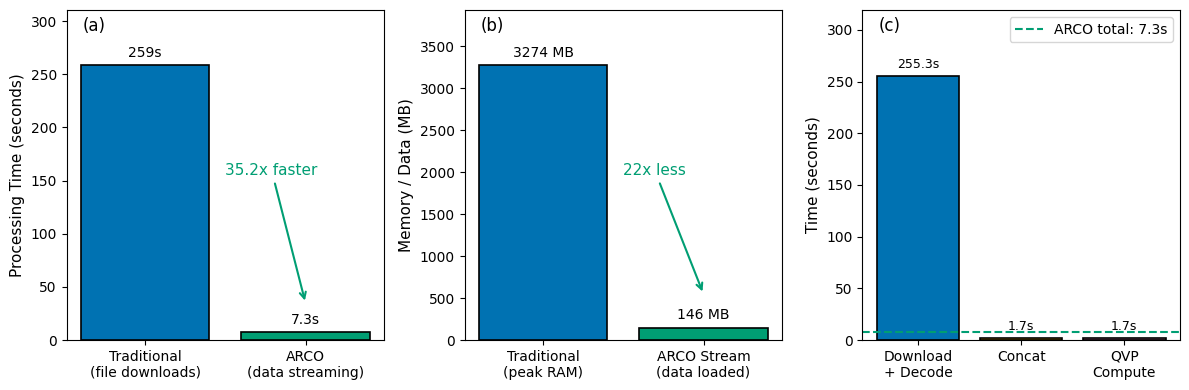

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# --------------------------------------------------
# Global style: match the clean VCP figure
# --------------------------------------------------
mpl.rcParams.update(
    {
        "font.family": "DejaVu Sans",
        "font.size": 10,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)

# --------------------------------------------------
# Colorblind-safe colors
# --------------------------------------------------
cb_colors = {
    "blue": "#0072B2",
    "green": "#009E73",
    "orange": "#E69F00",
    "purple": "#CC79A7",
}

# --------------------------------------------------
# Create figure with 3 subplots
# --------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# --------------------------------------------------
# 1. Time comparison
# --------------------------------------------------
categories = ["Traditional\n(file downloads)", "ARCO\n(data streaming)"]
times = [metrics["traditional"]["total_workflow_time"], metrics["arco"]["total_time"]]
colors = [cb_colors["blue"], cb_colors["green"]]

ax1 = axes[0]
bars = ax1.bar(categories, times, color=colors, edgecolor="black", linewidth=1.2)
ax1.set_ylabel("Processing Time (seconds)")
# ax1.set_title('Time to Process 4-Hour Window')
ax1.set_ylim(0, max(times) * 1.2)

label_offset = max(times) * 0.02
arrow_target_offset = max(times) * 0.03

for bar, time_val in zip(bars, times, strict=False):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + label_offset,
        f"{time_val:.0f}s" if time_val > 60 else f"{time_val:.1f}s",
        ha="center",
        va="bottom",
    )

arrow_target = metrics["arco"]["total_time"] - arrow_target_offset
arrow_start = metrics["traditional"]["total_workflow_time"] * 0.6

ax1.annotate(
    f"{speedup:.1f}x faster",
    xy=(1, arrow_target + 35),
    xytext=(0.5, arrow_start),
    fontsize=11,
    color=cb_colors["green"],
    arrowprops=dict(arrowstyle="->", color=cb_colors["green"], lw=1.5),
)

# --------------------------------------------------
# 2. Memory usage comparison
# --------------------------------------------------
ax2 = axes[1]
memory_categories = ["Traditional\n(peak RAM)", "ARCO Stream\n(data loaded)"]
memory_sizes = [
    metrics["traditional"]["peak_memory_mb"],
    metrics["arco"]["uncompressed_mb"],
]

bars2 = ax2.bar(
    memory_categories,
    memory_sizes,
    color=[cb_colors["blue"], cb_colors["green"]],
    edgecolor="black",
    linewidth=1.2,
)
ax2.set_ylabel("Memory / Data (MB)")
# ax2.set_title('RAM Usage Comparison')
ax2.set_ylim(0, max(memory_sizes) * 1.2)

label_offset_mem = max(memory_sizes) * 0.02
arrow_target_mem = metrics["arco"]["uncompressed_mb"] - max(memory_sizes) * 0.03
arrow_start_mem = metrics["traditional"]["peak_memory_mb"] * 0.6

for bar, size in zip(bars2, memory_sizes, strict=False):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + label_offset_mem,
        f"{size:.0f} MB",
        ha="center",
        va="bottom",
    )

memory_ratio = (
    metrics["traditional"]["peak_memory_mb"] / metrics["arco"]["uncompressed_mb"]
)
ax2.annotate(
    f"{memory_ratio:.0f}x less",
    xy=(1, arrow_target_mem + 500),
    xytext=(0.5, arrow_start_mem),
    fontsize=11,
    color=cb_colors["green"],
    arrowprops=dict(arrowstyle="->", color=cb_colors["green"], lw=1.5),
)

# --------------------------------------------------
# 3. Breakdown of Traditional workflow
# --------------------------------------------------
ax3 = axes[2]
trad_components = ["Download\n+ Decode", "Concat", "QVP\nCompute"]
trad_times = [
    metrics["traditional"]["total_time"],
    metrics["traditional"]["concat_time"],
    metrics["traditional"]["qvp_compute_time"],
]

bars3 = ax3.bar(
    trad_components,
    trad_times,
    color=[cb_colors["blue"], cb_colors["orange"], cb_colors["purple"]],
    edgecolor="black",
    linewidth=1.2,
)
ax3.set_ylabel("Time (seconds)")
# ax3.set_title('Traditional Workflow Breakdown')
ax3.set_ylim(0, max(trad_times) * 1.25)

label_offset_trad = max(trad_times) * 0.02

for bar, time_val in zip(bars3, trad_times, strict=False):
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + label_offset_trad,
        f"{time_val:.1f}s",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Horizontal reference line for ARCO total time
ax3.axhline(
    y=metrics["arco"]["total_time"],
    color=cb_colors["green"],
    linestyle="--",
    linewidth=1.5,
    label=f"ARCO total: {metrics['arco']['total_time']:.1f}s",
)
ax3.legend(loc="upper right")


panel_labels = ["(a)", "(b)", "(c)"]
for ax, label in zip(axes, panel_labels, strict=False):
    ax.text(0.05, 0.98, label, transform=ax.transAxes, fontsize=12, va="top", ha="left")

# --------------------------------------------------
# Layout and Save
# --------------------------------------------------
plt.tight_layout()
plt.savefig("workflow_comparison_cleaned.png", dpi=150, bbox_inches="tight")
plt.show()

---
## Key Takeaways

This analysis demonstrates the principles outlined in [Abernathey et al. (2021)](https://doi.org/10.1109/MCSE.2021.3059437) for cloud-native scientific data repositories.

### ARCO Principles Applied to Radar Data

**Analysis-Ready, Cloud-Optimized (ARCO)** data, as defined by Abernathey et al., represents the "gold standard" for cloud-native repositories. Our Radar DataTree implementation embodies these principles:

1. **Elimination of Scientific Toil**: The traditional workflow requires "manual, repetitive, automatable" work—downloading files, parsing filenames, looping through data, concatenating arrays. ARCO eliminates this toil:
   ```python
   # Traditional: ~50 lines of file iteration, download, decode, concat
   # ARCO: Single declarative selection
   ds.sel(vcp_time=slice("2011-05-20T08:30", "2011-05-20T12:30")).compute()
   ```

2. **Cloud-Optimized Format (Zarr/Icechunk)**: Data organized in chunks that enable:
   - HTTP-based access without filesystem assumptions
   - Efficient subsetting (only requested chunks are fetched)
   - Parallel distributed processing

3. **FAIR Principles Enhanced**:
   - **Findable**: Hierarchical DataTree structure (VCP → sweep → variable)
   - **Accessible**: Global namespace (`s3://`) enables portable, reproducible code
   - **Interoperable**: CF-compliant metadata, standard xarray interface
   - **Reusable**: Versioned with Icechunk for reproducibility

4. **Selective Data Access**: The key advantage of ARCO is **not compression** but **selective access**. Traditional workflows download entire files (all sweeps, all variables) even when only a subset is needed. ARCO streams exactly the chunks required—nothing more.

### Performance Summary

We measure **effective throughput** = useful data delivered / total workflow time.

Both workflows deliver the same 146 MB of useful data (4 variables × 55 timesteps × 1 sweep) for QVP analysis:

```{list-table} Measured Performance (Fair Comparison)
:header-rows: 1
:widths: 35 25 25 15

* - Metric
  - Traditional
  - ARCO Streaming
  - Gain
* - Total Time
  - ~260 seconds
  - ~8 seconds
  - **32x faster**
* - Peak RAM
  - 3,274 MB
  - 146 MB
  - **22x less**
* - Network Transfer
  - 809 MB (gzip)
  - 146 MB (uncompressed)
  - **5.5x less**
* - Effective Throughput
  - 0.56 MB/s
  - 18 MB/s
  - **32x higher**
```

**Key insight**: ARCO's advantage comes from **selective access**—streaming only the 146 MB of chunks needed instead of downloading 809 MB of compressed files (which decompress to ~3,200 MB in RAM). Even without compression in the ARCO store, we transfer 5.5x less data because we only fetch what we need.

### Scalability

The same ARCO pattern scales from hours to years:
- **4 hours** (this demo): ~8 seconds
- **1 day**: ~48 seconds (estimated)
- **1 month**: ~24 minutes (estimated)
- **1 year**: ~5 hours (estimated)

Traditional file-based workflows scale linearly with data volume. ARCO maintains consistent per-chunk access patterns regardless of total dataset size.

### When to Use Each Approach

```{list-table} Recommended Workflow by Use Case
:header-rows: 1
:widths: 50 50

* - Use Case
  - Recommended Approach
* - Single file exploration (local)
  - Traditional
* - Time-series analysis (single sweep)
  - **ARCO streaming**
* - Multi-sweep analysis
  - **ARCO streaming** (select sweeps needed)
* - Large-scale processing (months/years)
  - **ARCO streaming**
* - Reproducible research
  - **ARCO** (versioned with Icechunk)
* - Machine learning training
  - **ARCO** (high-throughput chunk access)
```

## References

* Abernathey, R.P., T. Augspurger, A. Banihirwe, C.C. Blackmon-Luca, T.J. Crone, C.L. Gentemann, J.J. Hamman, N. Henderson, C. Lepore, T.A. McCaie, N.H. Robinson, and R.P. Signell, 2021: Cloud-Native Repositories for Big Scientific Data. *Computing in Science & Engineering*, **23**, 26–35, https://doi.org/10.1109/MCSE.2021.3059437.

* Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Trömel, and C. Simmer, 2016: Quasi-Vertical Profiles—A New Way to Look at Polarimetric Radar Data. *J. Atmos. Oceanic Technol.*, **33**, 551–562, https://doi.org/10.1175/JTECH-D-15-0020.1.

* Wilkinson, M.D., et al., 2016: The FAIR Guiding Principles for scientific data management and stewardship. *Scientific Data*, **3**, 160018, https://doi.org/10.1038/sdata.2016.18.